In [ ]:
import os
import shutil
import random
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset

import torchvision.transforms as T
import torchvision.datasets as dset
import torchvision.models as models

from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split


using_platform = 'colab'

dataset_path = None
if using_platform == 'colab':
    import kagglehub
    dataset_path = kagglehub.dataset_download("jagachau/weather-dataset")
    dataset_path = os.path.join(dataset_path, 'weather_dataset')
elif using_platform == 'kaggle':
    dataset_path = '/kaggle/input/weather-dataset/weather_dataset'
else:
    print('invalid platform')

print('dataset path:', dataset_path)

seed = 4471
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)

moved = False

# For precise error position
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('using device:', device)
print('GPU count:', torch.cuda.device_count())

dataset path: /kaggle/input/weather-dataset/weather_dataset
using device: cuda
GPU count: 1


In [ ]:
classes = ['fogsmog', 'sandstorm']
num_classes = len(classes)

dset_path = '/kaggle/working/dset'

if not moved:
	os.makedirs(dset_path, exist_ok=True)
	for c in classes:
		try:
			shutil.move(os.path.join(dataset_path, c), dset_path)
		except:
			...
	moved = True

print("Images count")

total = 0
class_counts = []
for weather in classes:
	count = len(os.listdir(os.path.join(dset_path, weather)))
	total += count
	class_counts.append(count)
	print(f"{weather:9} : {count:4}")

print(f"Total: {num_classes} classes with {total} images")

Images count
fogsmog   :  851
sandstorm :  692
Total: 2 classes with 1543 images


In [ ]:
def split_dataset(altered_dataset, original_dataset, train_ratio=0.8, batch_size=64):
	workers = torch.cuda.device_count() * 2 if torch.cuda.device_count() else 1
	targets = np.array(altered_dataset.targets)

	# Split per class
	train_indices = []
	val_indices = []

	for class_idx in range(len(classes)):
		class_indices = np.where(targets == class_idx)[0]
		class_size = len(class_indices)

		train_size = int(train_ratio * class_size)

		train_idx, val_idx = train_test_split(
			class_indices,
			train_size=train_size,
			random_state=seed
		)

		train_indices.extend(train_idx)
		val_indices.extend(val_idx)

	train_dataset = Subset(altered_dataset, train_indices)
	val_dataset = Subset(original_dataset, val_indices)

	train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=workers)
	val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=workers)

	print(f"Train set size: {len(train_dataset)}")
	print(f"Validation set size: {len(val_dataset)}")

	return train_loader, val_loader

In [ ]:
resnet_mean = [0.485, 0.456, 0.406]
resnet_sd = [0.229, 0.224, 0.225]

transform_train = T.Compose([
    T.Resize((224, 224)),
    T.RandomHorizontalFlip(p=0.5),   
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    T.RandomAffine(degrees=0, translate=(0.1, 0.1)), 
    T.RandomPerspective(distortion_scale=0.2, p=0.5),
    T.RandomResizedCrop(size=224, scale=(0.8, 1.0)),
    T.ToTensor(),
    T.Normalize(mean=resnet_mean, std=resnet_sd)
])

transform_val = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=resnet_mean, std=resnet_sd)
])

altered_dataset = dset.ImageFolder(root=dset_path, transform=transform_train)
original_dataset = dset.ImageFolder(root=dset_path, transform=transform_val)
print(original_dataset.classes)

train_loader, val_loader = split_dataset(altered_dataset, original_dataset, 0.8, 128)

['fogsmog', 'sandstorm']
Train set size: 1233
Validation set size: 310


In [ ]:
def get_model():
    model = models.resnet50(weights='DEFAULT')
    
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, 1)
    model.to(device)
    
    for param in model.parameters():
        param.requires_grad = False
    for param in model.fc.parameters():
        param.requires_grad = True
        
    for param in model.layer4.parameters():
        param.requires_grad = True
        
    return model

def train_binary_model(model, train_loader, val_loader, optimizer, scheduler, epochs=30, pos_weight=None):
    if pos_weight is not None:
        criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([pos_weight], device=device))
    else:
        criterion = nn.BCEWithLogitsLoss()
    
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    best_val_acc = 0
    best_model_state = None
    
    for e in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        correct = 0
        total = 0
        batch_bar = tqdm(train_loader, desc=f"Epoch {e+1}: Train")
        
        for x, y in batch_bar:
            x = x.to(device)
            # Convert labels to binary format (0 or 1) and reshape
            y_binary = y.float().to(device).view(-1, 1)
            
            # Forward pass (outputs a single value per image)
            outputs = model(x)
            loss = criterion(outputs, y_binary)
            
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Calculate accuracy
            train_loss += loss.item()
            predicted = (torch.sigmoid(outputs) > 0.5).float()
            total += y_binary.size(0)
            correct += (predicted == y_binary).sum().item()
            
            batch_acc = 100 * correct / total
            batch_bar.set_postfix({"Train loss": f"{train_loss/len(batch_bar):.4f}", 
                                  "Train acc": f"{batch_acc:.2f}%"})
        
        scheduler.step()
        train_acc = 100 * correct / total
        train_accs.append(train_acc)
        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            batch_bar = tqdm(val_loader, desc=f"Epoch {e+1}: Validation")
            for x, y in batch_bar:
                x = x.to(device)
                y_binary = y.float().to(device).view(-1, 1)
                
                outputs = model(x)
                loss = criterion(outputs, y_binary)
                
                val_loss += loss.item()
                predicted = (torch.sigmoid(outputs) > 0.5).float()
                total += y_binary.size(0)
                correct += (predicted == y_binary).sum().item()
                
                batch_acc = 100 * correct / total
                batch_bar.set_postfix({"Val loss": f"{val_loss/len(batch_bar):.4f}", 
                                      "Val acc": f"{batch_acc:.2f}%"})
        
        val_acc = 100 * correct / total
        val_accs.append(val_acc)
        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        
        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict().copy()
            print(f"New best model saved with validation accuracy: {val_acc:.2f}%")
    
    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print(f"Loaded best model with validation accuracy: {best_val_acc:.2f}%")
    
    return train_losses, val_losses, train_accs, val_accs, model

def loss_acc_plot(train_losses, val_losses, train_accs, val_accs):
	# Plot loss
	plt.figure(figsize=(8, 6))
	plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss', marker='o')
	plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss', marker='o')
	plt.xlabel('Epoch')
	plt.ylabel('Loss')
	plt.title('Training and Validation Loss')
	plt.legend()
	plt.grid(True)
	plt.tight_layout()
	plt.show()

	# Plot accuracy
	plt.figure(figsize=(8, 6))
	plt.plot(range(1, len(train_accs) + 1), train_accs, label='Training Accuracy', marker='o')
	plt.plot(range(1, len(val_accs) + 1), val_accs, label='Validation Accuracy', marker='o')
	plt.xlabel('Epoch')
	plt.ylabel('Accuracy (%)')
	plt.title('Training and Validation Accuracy')
	plt.legend()
	plt.grid(True)
	plt.tight_layout()
	plt.show()

def inference(model, loader):
	model.eval()
	correct = 0
	total = 0
	with torch.no_grad():
		for inputs, labels in tqdm(loader, desc='Inference'):
			inputs, labels = inputs.to(device), labels.to(device)
			outputs = model(inputs)
			_, predicted = torch.max(outputs, 1)
			total += labels.size(0)
			correct += (predicted == labels).sum().item()
	test_acc = 100 * correct / total
	print(f"Accuracy: {test_acc:.2f}%")

def get_predictions_and_probs(model, loader):
    model.eval()
    all_labels, all_preds, all_probs = [], [], []
    with torch.no_grad():
        for inputs, labels in tqdm(loader, desc="Loading"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).int()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.view(-1).cpu().numpy())
            all_probs.extend(probs.view(-1).cpu().numpy())
    return np.array(all_labels), np.array(all_preds), np.array(all_probs)

def get_class_weights(class_counts):
	class_counts = np.array(class_counts)
	class_weights = 1.0 / class_counts
	class_weights = class_weights / class_weights.sum() * len(class_counts)
	return torch.tensor(class_weights, dtype=torch.float32, device=device)

Epoch 1: Validation: 100%|██████████| 3/3 [00:02<00:00,  1.36it/s, Val loss=0.7922, Val acc=58.39%]


New best model saved with validation accuracy: 58.39%


Epoch 2: Validation: 100%|██████████| 3/3 [00:02<00:00,  1.32it/s, Val loss=0.7481, Val acc=70.32%]


New best model saved with validation accuracy: 70.32%


Epoch 3: Validation: 100%|██████████| 3/3 [00:02<00:00,  1.36it/s, Val loss=0.7007, Val acc=82.90%]


New best model saved with validation accuracy: 82.90%


Epoch 4: Validation: 100%|██████████| 3/3 [00:02<00:00,  1.36it/s, Val loss=0.6664, Val acc=85.81%]


New best model saved with validation accuracy: 85.81%


Epoch 5: Validation: 100%|██████████| 3/3 [00:02<00:00,  1.37it/s, Val loss=0.6276, Val acc=86.13%]


New best model saved with validation accuracy: 86.13%


Epoch 7: Validation: 100%|██████████| 3/3 [00:02<00:00,  1.25it/s, Val loss=0.5478, Val acc=86.45%]


New best model saved with validation accuracy: 86.45%


Epoch 8: Validation: 100%|██████████| 3/3 [00:02<00:00,  1.33it/s, Val loss=0.4997, Val acc=87.42%]


New best model saved with validation accuracy: 87.42%


Epoch 9: Validation: 100%|██████████| 3/3 [00:02<00:00,  1.35it/s, Val loss=0.4595, Val acc=88.71%]


New best model saved with validation accuracy: 88.71%


Epoch 10: Validation: 100%|██████████| 3/3 [00:02<00:00,  1.36it/s, Val loss=0.4290, Val acc=89.35%]


New best model saved with validation accuracy: 89.35%


Epoch 11: Validation: 100%|██████████| 3/3 [00:02<00:00,  1.34it/s, Val loss=0.3899, Val acc=89.68%]


New best model saved with validation accuracy: 89.68%


Epoch 12: Validation: 100%|██████████| 3/3 [00:02<00:00,  1.25it/s, Val loss=0.3647, Val acc=90.32%]


New best model saved with validation accuracy: 90.32%


Epoch 13: Validation: 100%|██████████| 3/3 [00:02<00:00,  1.35it/s, Val loss=0.3439, Val acc=90.65%]


New best model saved with validation accuracy: 90.65%


Epoch 15: Validation: 100%|██████████| 3/3 [00:02<00:00,  1.33it/s, Val loss=0.3062, Val acc=90.97%]


New best model saved with validation accuracy: 90.97%


Epoch 16: Validation: 100%|██████████| 3/3 [00:02<00:00,  1.36it/s, Val loss=0.3025, Val acc=92.26%]


New best model saved with validation accuracy: 92.26%


Epoch 18: Validation: 100%|██████████| 3/3 [00:02<00:00,  1.35it/s, Val loss=0.2808, Val acc=92.58%]


New best model saved with validation accuracy: 92.58%


Epoch 23: Validation: 100%|██████████| 3/3 [00:02<00:00,  1.35it/s, Val loss=0.2710, Val acc=93.23%]


New best model saved with validation accuracy: 93.23%


Epoch 24: Validation: 100%|██████████| 3/3 [00:02<00:00,  1.35it/s, Val loss=0.2628, Val acc=93.55%]


New best model saved with validation accuracy: 93.55%


Epoch 26: Validation: 100%|██████████| 3/3 [00:02<00:00,  1.34it/s, Val loss=0.2631, Val acc=93.87%]


New best model saved with validation accuracy: 93.87%


Epoch 27: Validation: 100%|██████████| 3/3 [00:02<00:00,  1.33it/s, Val loss=0.2620, Val acc=94.19%]


New best model saved with validation accuracy: 94.19%


Epoch 30: Validation: 100%|██████████| 3/3 [00:02<00:00,  1.37it/s, Val loss=0.2527, Val acc=92.90%]


Loaded best model with validation accuracy: 94.19%


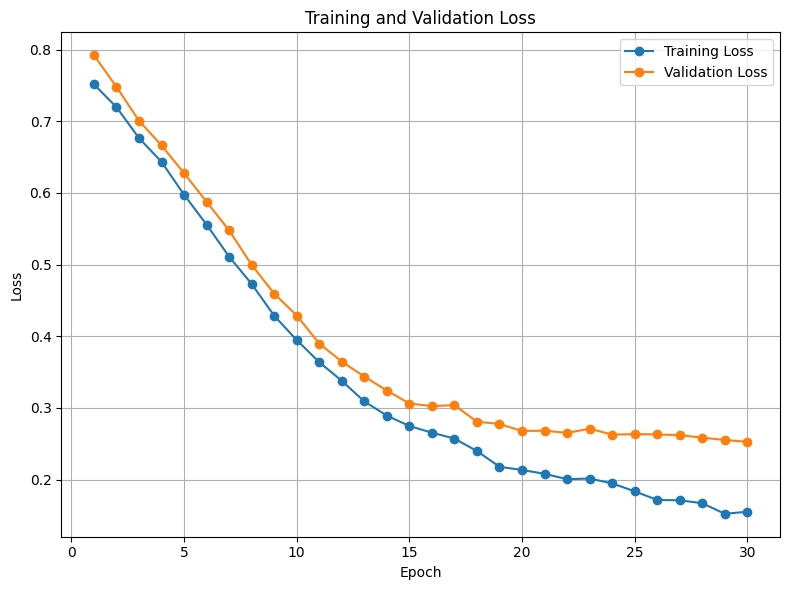

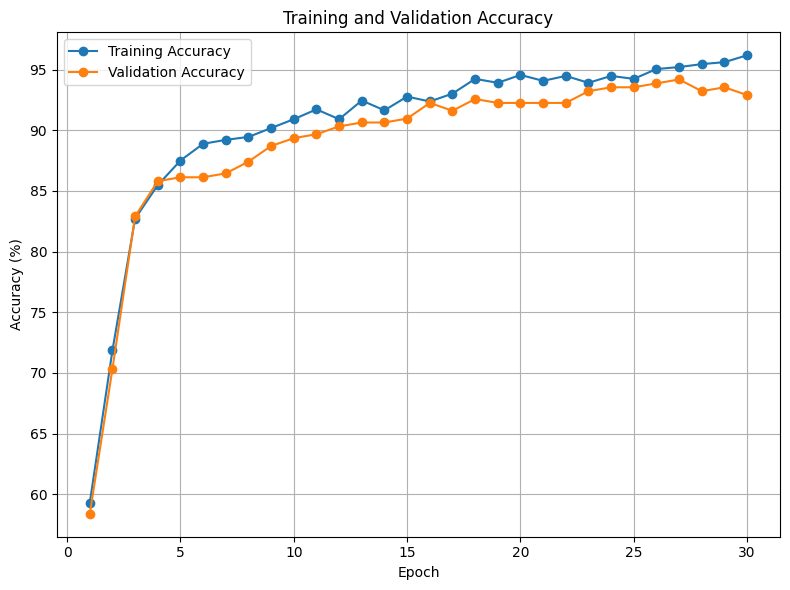

In [16]:
epochs = 30
learning_rate = 1e-4

model = get_model()
optimizer = optim.Adam([
    {'params': model.fc.parameters(), 'lr': learning_rate},
    {'params': model.layer4.parameters(), 'lr': learning_rate/10}
])
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.9)

class_ratio = class_counts[0] / class_counts[1]
pos_weight = class_ratio if class_counts[0] > class_counts[1] else 1.0

# Train the model
train_losses, val_losses, train_accs, val_accs, model = train_binary_model(
    model, train_loader, val_loader, optimizer, scheduler, epochs, pos_weight)

# Save the model
torch.save(model, 'foggy_model2.pth')

loss_acc_plot(train_losses, val_losses, train_accs, val_accs)

Loading: 100%|██████████| 3/3 [00:02<00:00,  1.36it/s]


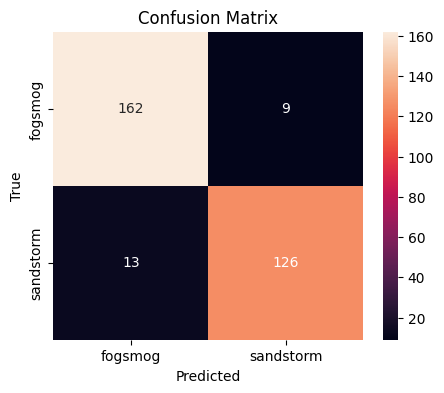

In [17]:
labels, preds, probs = get_predictions_and_probs(model, val_loader)

cm = confusion_matrix(labels, preds)
plt.figure(figsize=(5, 4))
sb.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()